# Project Title

## Introduction and description

 This dataset contains information from inspections of restaurants and other
food establishments in Chicago from January 1, 2010 to the present. 

(...)

## Exploratory Data Analysis

**Data Loading**

In [39]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import warnings

In [40]:
# Pre-processed Data
food_inspections = pd.read_pickle("food.pkl")
restaurants = pd.read_pickle("restaurants.pkl")

In [41]:
food_inspections.columns

Index(['Inspection ID', 'DBA Name', 'AKA Name', 'License #', 'Facility Type',
       'Risk', 'Zip', 'Inspection Date', 'Inspection Type', 'Results',
       'Violations', 'Latitude', 'Longitude', 'geometry', 'community', 'area',
       'shape_area', 'area_num_1', 'area_numbe', 'shape_len'],
      dtype='object')

### Studying the Violations

We check if there are entries with no violations. If there is no violation, nothing was detected in those restaurants.

In [42]:
food_inspections['Violations'].isnull().values.any()

True

In [43]:
print('Total number of entries in the dataset: {0}'.format(food_inspections.shape[0]))

Total number of entries in the dataset: 147455


In [44]:
print('Total number of entries with no violations in the dataset: {0}'\
      .format(food_inspections[food_inspections['Violations'].isnull()].shape[0]))
per = food_inspections[food_inspections['Violations'].isnull()].shape[0]/food_inspections.shape[0]
print('Corresponding the following percentage of entries: {0:.2f}'\
      .format(per))

Total number of entries with no violations in the dataset: 21814
Corresponding the following percentage of entries: 0.15


We fill those NaN values with the tag 'No Violation' for better readibility during counting. We will then inspect the violations data to see its shape.

In [45]:
food_inspections['Violations'].fillna('No Violation', inplace=True)

We observe that the violations are referenced using a 'number', a 'description' and a comment for more specificities. In our case, we don't need the comment part so we delete it. The 'Violations' column can as well contain more than one violation type, we can split those into arrays and create a new violation-based dataset.

In [46]:
food_inspections['Violations'] = food_inspections.Violations.apply(lambda x: x.split('- Comments:')[0])

In [47]:
food_inspections['Violations'] = np.array(food_inspections.Violations.apply(lambda x: x.split('|')))

In [48]:
food_inspections = pd.DataFrame(food_inspections)

**Create Violation based dataset**

In [49]:
violations = food_inspections.explode('Violations')\
                    .rename(columns={'Violations':'Violation'}) \
                    .reset_index(drop=True) \
                    .dropna(subset=['Violation']) \
                    .set_index('Violation') \
                    .reset_index()

In [50]:
len(violations.Violation.unique())

165

**Violation ID and Delete No Violation**

In [51]:
violations['Violation ID'] = violations['Violation']
violations['Violation ID'] = violations['Violation ID'].apply(lambda x: x.split('.')[0])
violations = violations[violations['Violation ID'] != 'No Violation']

**Count using ID**

In [52]:
def get_counts(df):
    df_count = df[['Violation','Violation ID','Inspection ID']].groupby(['Violation','Violation ID'])\
                    .count()\
                    .sort_values(by='Inspection ID', ascending=False)\
                    .rename(columns={'Inspection ID':'Occurence'})

    df_count.reset_index(inplace=True)
    df_count.sort_values(by='Violation ID', ascending=True, inplace=True)
    
    df_count = df_count[['Violation ID','Occurence']]
    df_count = df_count.groupby('Violation ID', as_index=False).sum()
    sum_ = df_count['Occurence'].sum()
    df_count['Frequency'] = df_count['Occurence']/sum_ 
    df_count.sort_values(by='Occurence', ascending=False, inplace=True)
    return df_count

In [53]:
violation_count = get_counts(violations)
violation_count.head()

,Violation ID,Occurence,Frequency
62,32,22826,0.181031
63,33,15555,0.123365
59,3,11930,0.094616
64,34,8966,0.071109
60,30,8735,0.069276


**Plotting Violations**

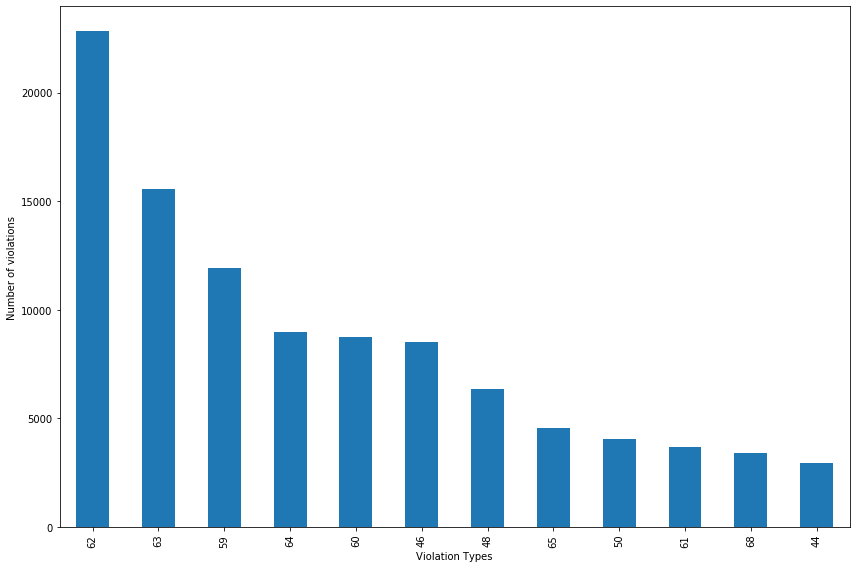

In [54]:
# Plot 13 top values
ax = violation_count.Occurence.iloc[0:12].plot(kind='bar',figsize = [12,8])
ax.set_xlabel('Violation Types')
ax.set_ylabel('Number of violations')
plt.tight_layout()

**Separe violations by results**

In [55]:
violations.Results.unique()

array(['Fail', 'Pass w/ Conditions', 'Pass'], dtype=object)

In [56]:
violations_fail = violations[violations['Results'] == 'Fail']
violations_pass = violations[violations['Results'] == 'Pass']
violations_cond = violations[violations['Results'] == 'Pass w/ Conditions']

In [57]:
violations_fail_count = get_counts(violations_fail)
violations_pass_count = get_counts(violations_pass)
violations_cond_count = get_counts(violations_cond)

In [58]:
violations_fail_count.head()

,Violation ID,Occurence,Frequency
36,18,8365,0.278332
49,3,3441,0.114494
38,2,3362,0.111865
34,16,1963,0.065316
48,29,1717,0.057130


In [59]:
violations_pass_count.head()

,Violation ID,Occurence,Frequency
45,32,22318,0.308426
46,33,15360,0.212269
47,34,8854,0.122359
43,30,8603,0.118890
48,35,4493,0.062091


In [60]:
violations_cond_count.head()

,Violation ID,Occurence,Frequency
43,3,8455,0.357143
34,21,3557,0.150249
32,2,2927,0.123638
64,5,1025,0.043296
28,16,920,0.038861


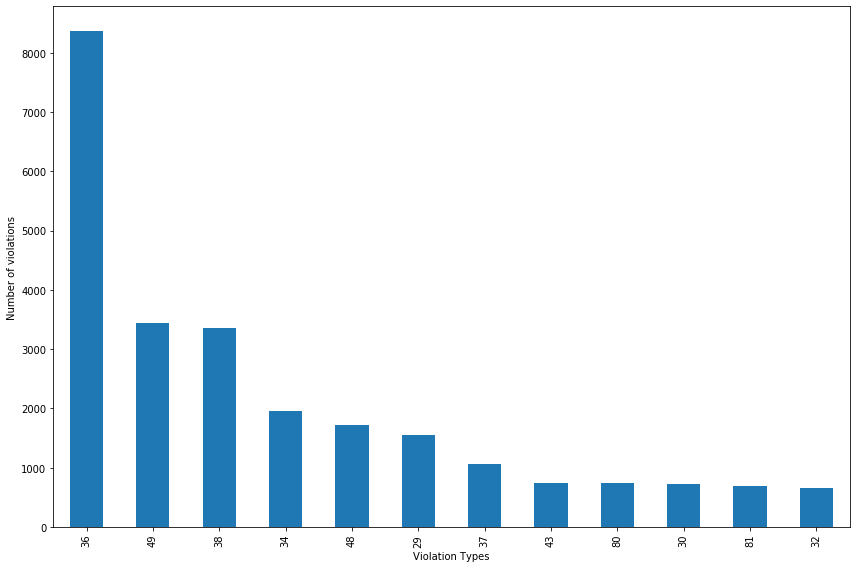

In [61]:
# Plot 13 top values
ax = violations_fail_count.Occurence.iloc[0:12].plot(kind='bar',figsize = [12,8])
ax.set_xlabel('Violation Types')
ax.set_ylabel('Number of violations')
plt.tight_layout()

In [62]:
labels_pass = np.array(violations_pass_count['Violation ID'])

In [63]:
labels_pass

array(['32', '33', '34', '30', '35', '31', '38', '36', '41', '37', '40',
       '55', '45', '47', '51', '49', '10', '42', '43', '16', '39', '18',
       '58', '2', '53', ' 35', '44', '56', ' 34', '57', '8', ' 38', '21',
       '3', ' 33', '29', ' 41', '23', '25', ' 36', '24', ' 40', '48',
       '52', ' 32', '5', '19', '11', '28', '54', '6', ' 37', '27', '12',
       ' 43', ' 31', '26', '22', '1', ' 55', '9', '14', ' 42', '20', '15',
       ' 30', '4', ' 25', '17', '13', ' 57', ' 53', ' 51', '59', ' 39',
       ' 24'], dtype=object)

In [64]:
merged = violation_count.merge(violations_pass_count, on='Violation ID', left_index=True)
merged.rename(columns={"Occurence_x": "Occurence All", "Frequency_x": "Frequency All"}, inplace=True)
merged.rename(columns={"Occurence_y": "Occurence Pass", "Frequency_y": "Frequency Pass"}, inplace=True)

merged = merged.merge(violations_fail_count, on='Violation ID', left_index=True)
merged.rename(columns={"Occurence": "Occurence Fail", "Frequency": "Frequency Fail"}, inplace=True)

merged = merged.merge(violations_cond_count, on='Violation ID', left_index=True)
merged.rename(columns={"Occurence": "Occurence w/ Cond.", "Frequency": "Frequency w/ Cond."}, inplace=True)

merged.head()

,Violation ID,Occurence All,Frequency All,Occurence Pass,Frequency Pass,Occurence Fail,Frequency Fail,Occurence w/ Cond.,Frequency w/ Cond.
46,32,22826,0.181031,22318,0.308426,341,0.011346,167,0.007054
47,33,15555,0.123365,15360,0.212269,117,0.003893,78,0.003295
43,3,11930,0.094616,34,0.000470,3441,0.114494,8455,0.357143
48,34,8966,0.071109,8854,0.122359,71,0.002362,41,0.001732
44,30,8735,0.069276,8603,0.118890,63,0.002096,69,0.002915


In [65]:
sub_merged = merged[['Occurence Pass','Occurence Fail', 'Occurence w/ Cond.']].copy()
sub_merged.rename(columns={'Occurence Pass': "Pass", 'Occurence Fail': "Fail", \
                           "Occurence w/ Cond.":'Pass w/ cond'}, inplace=True)
sub_merged.head()

,Pass,Fail,Pass w/ cond
46,22318,341,167
47,15360,117,78
43,34,3441,8455
48,8854,71,41
44,8603,63,69


In [66]:
sub_merged.sort_values(by='Fail', inplace=True, ascending=False)
sub_merged.head()

,Pass,Fail,Pass w/ cond
30,72,8365,101
43,34,3441,8455
32,54,3362,2927
28,86,1963,920
42,24,1717,207


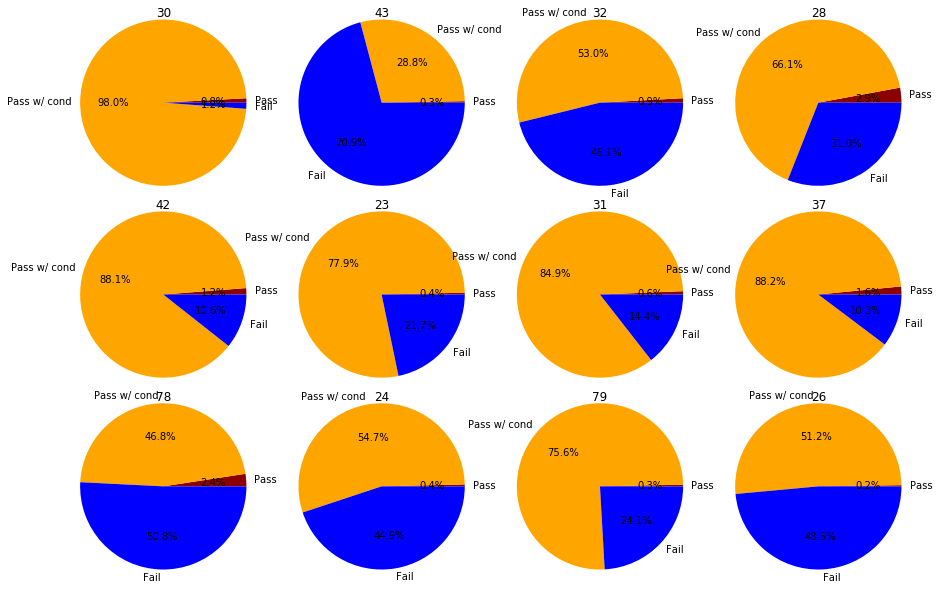

In [67]:
#plotting
top = 5
violation_list = sub_merged.index

labels = ['Pass', 'Pass w/ cond', 'Fail']
fig, ax= plt.subplots(3, 4, figsize=(15,10))

first=0
for i in range(3):
    for j in range(4):
        
        ax[i,j].pie(sub_merged.iloc[first].to_list(), labels = labels, radius = 1.3,
                    autopct='%1.1f%%', colors=["darkred","orange","blue"])
        ax[i,j].set_title(violation_list[first])
        first += 1

plt.show()

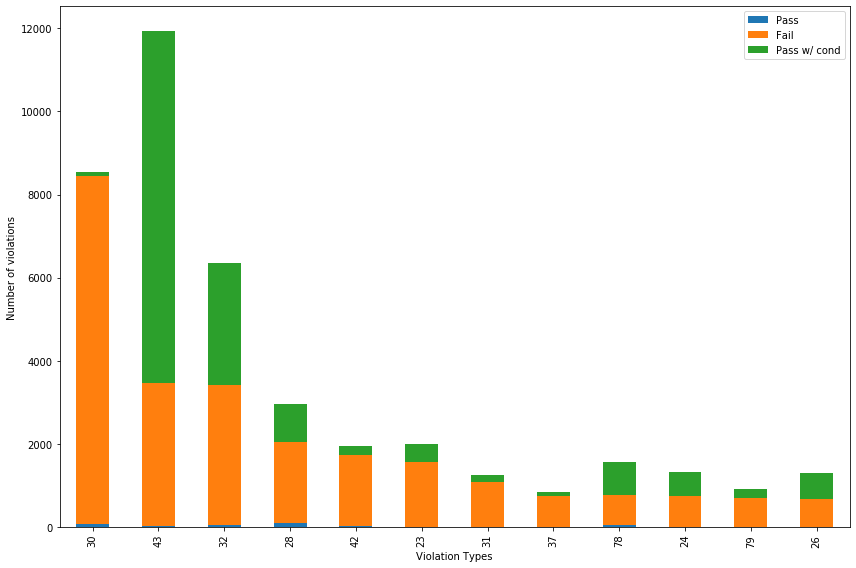

In [68]:
# Plot 13 top values
ax = sub_merged.iloc[0:12].plot(kind='bar',figsize = [12,8], stacked=True)
ax.set_xlabel('Violation Types')
ax.set_ylabel('Number of violations')
plt.tight_layout()

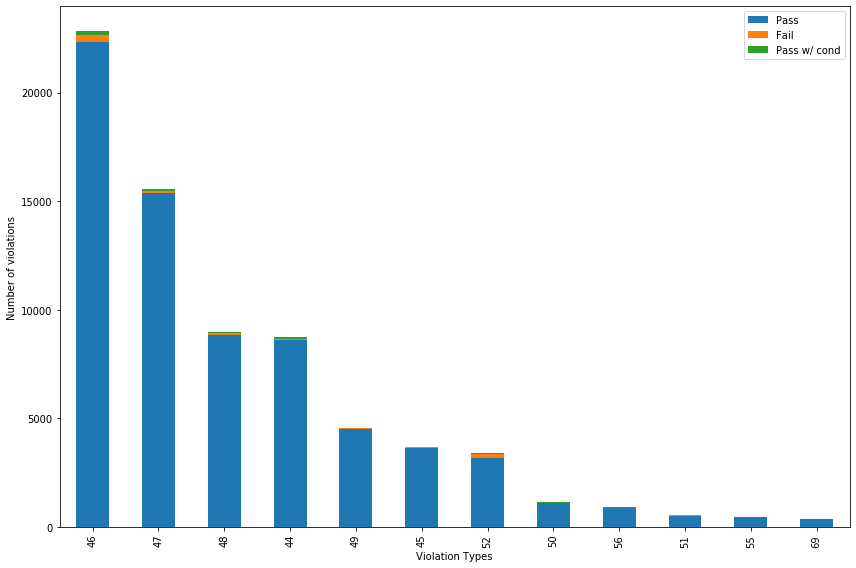

In [69]:
# Plot 13 top values
sub_merged.sort_values(by='Pass', inplace=True, ascending=False)
ax = sub_merged.iloc[0:12].plot(kind='bar',figsize = [12,8], stacked=True)
ax.set_xlabel('Violation Types')
ax.set_ylabel('Number of violations')
plt.tight_layout()

**Violations per establishment**

In [75]:
restaurants_top5 = pd.read_pickle("restaurants.pkl")

In [79]:
restaurants_top5 = restaurants_top5.merge(violations[['Inspection ID','Violation ID']], on='Inspection ID')
restaurants_top5.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Violation ID
0,2320374,DUNKIN DONUTS/BASKIN ROBBINS,DUNKIN DONUTS,1909364.0,Restaurant,Risk 2 (Medium),29,2019,Complaint Re-Inspection,Fail,"38. INSECTS, RODENTS, & ANIMALS NOT PRESENT - ...",41.766871,-87.722317,38
1,2320281,DUNKIN DONUTS,DUNKIN DONUTS,2698419.0,Restaurant,Risk 2 (Medium),06,2019,License,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.881835,-87.633897,3
2,2316183,MCDONALDS,MCDONALDS,64032.0,Restaurant,Risk 1 (High),66,2019,Canvass,Pass,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,42.008536,-87.914428,10
3,2316196,MCDONALD'S RESTAURANT,MCDONALDS,51206.0,Restaurant,Risk 1 (High),66,2019,Canvass,Pass,36. THERMOMETERS PROVIDED & ACCURATE - Comment...,42.008536,-87.914428,36
4,2316054,SUBWAY,SUBWAY,2590201.0,Restaurant,Risk 1 (High),47,2019,Complaint Re-Inspection,Pass,39. CONTAMINATION PREVENTED DURING FOOD PREPAR...,41.910399,-87.690207,39


In [81]:
violation_resto = restaurants_top5.groupby(['AKA Name','DBA Name', 'License #','Longitude', 'Latitude'])\
                    .count()\
                    .sort_values(by='Inspection ID', ascending=False)

violation_resto = violation_resto[['Violation ID']]
violation_resto.reset_index(inplace=True)
violation_resto = violation_resto.rename(columns={'Violation ID':'Viol. Count'})

In [82]:
violation_resto.head()

,AKA Name,DBA Name,License #,Longitude,Latitude,Viol. Count
0,MCDONALDS,MCDONALD'S,1490035.0,-87.626813,41.769155,37
1,MCDONALDS,McDONALD'S,1302136.0,-87.622915,41.794794,32
2,SUBWAY,SUBWAY,1594765.0,-87.705855,41.867667,29
3,MCDONALDS,MCDONALD'S,33706.0,-87.705734,41.866514,27
4,MCDONALDS,McDONALDS,1519152.0,-87.615441,41.778597,27


In [84]:
violation_resto[violation_resto['DBA Name'] == 'MCDONALD\'S'].head()

,AKA Name,DBA Name,License #,Longitude,Latitude,Viol. Count
0,MCDONALDS,MCDONALD'S,1490035.0,-87.626813,41.769155,37
3,MCDONALDS,MCDONALD'S,33706.0,-87.705734,41.866514,27
5,MCDONALDS,MCDONALD'S,1874347.0,-87.683386,41.775117,26
16,MCDONALDS,MCDONALD'S,1514130.0,-87.621449,41.830953,20
19,MCDONALDS,MCDONALD'S,1943516.0,-87.586437,41.775220,19
